# Simulation of synthetic time series data

In this notebook, we aim to synthesise some *simple* time series data using the telegraph model, with two different labels e.g., normal and stressful conditions for the cells. The signals need to be produced as similarly to each other as much as possible so that it ressembles microfluidic time series data, and are harder for the ML algorithm to classify (see ``traj_classification.ipynb``).

## Import functions from the ``src`` folder

The functions to run the simulations are already in the ``src`` folder in the root directory of this repository. All we have to do is to import them in order to use them.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tqdm
from sympy import sqrt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
# Import all the functions from the 'src' directory, we import all the functions from each module so we can use them straight away
from ssa_simulation import simulate_two_telegraph_model_systems
from ssa_analysis import *
from ssa_classification import *
%load_ext autoreload
%autoreload 2

## Simulate two different systems

**The telegraph model:**

$$
G^{\star} \xrightleftharpoons[\sigma_{\text{u}}]{\sigma_{\text{b}}} G \xrightarrow{\rho} G + M, \quad M \xrightarrow{d} \emptyset
$$

**System 1:** Normal Condition (σ_u_normal = 9.0, σ_b_normal = 0.02)

**System 2:** Stressed Condition (σ_u_stress = 18.0, σ_b_stress = 0.01)

- Higher gene deactivation rate: genes encoding metabolic enzymes under stress do not stay active for long.
- Lower gene activation rate: stress often results in strong repression of transcription by repressors, which makes gene activation rarer.
This combination will lead to lower mRNA levels.

<!-- **Theoretical foundation:**

The equation for the mean mRNA levels at steady state, in terms of the system parameters, is:

$$ \mu = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} $$

The equation for the mRNA level variance at steady state, in terms of the system parameters, is: 

$$ \sigma ^2 = \frac{\sigma_b \rho}{d (\sigma_b + \sigma_u)} + \frac{\sigma_u \sigma_b}{({\sigma_u + \sigma_b})^2} \frac{\rho^2}{d(\sigma_u + \sigma_b + d)} $$

From these equations, we can fix the mean or variance to be the same by moving the terms around. Below is an example, to **fix the mean of the mRNA levels**.  -->

In [8]:
# Define activation/deactivation rates for two conditions
sigma_u_stress, sigma_b_stress = 18.0, 0.01  # Stressed Condition
sigma_u_normal, sigma_b_normal = 9.0, 0.02   # Normal Condition

# Define degradation rates
d_stress = d_normal = 1.0

# transcription rates (rho) 
rho_stress = 5
rho_normal = 10

# Updated parameter sets ensuring similar mean mRNA levels
parameter_sets = [
    {"sigma_u": sigma_u_stress, "sigma_b": sigma_b_stress, "rho": rho_stress, "d": d_stress, "label": 0},
    {"sigma_u": sigma_u_normal, "sigma_b": sigma_b_normal, "rho": rho_normal, "d": d_normal, "label": 1},
]

# Set up simulation parameters 
# !! Use np.arange to make sure evenly spaced values within a given interval, to match how exp data is collected at set time intervals !!
time_points = np.arange(0, 144.0, 1.0)  # Time range: start, stop, step; 
# 144 time points: to match experimental conditions, where typically a photo is taken every 5 min over 12 hours --> 144 time points

size = 200  # Reduce number of simulations per condition for efficiency

# Run the simulation function
df_results = simulate_two_telegraph_model_systems(parameter_sets, time_points, size)

# Save dataset for ML classification
output_file = "data/mRNA_trajectories_example.csv"
df_results.to_csv(output_file, index=False)

# Extract mRNA trajectories for each condition
stress_trajectories = df_results[df_results['label'] == 0].iloc[:, 1:].values  # Stressed Condition
normal_trajectories = df_results[df_results['label'] == 1].iloc[:, 1:].values  # Normal condition

# report the mean and variance of the mRNA counts at steady state
report = statistical_report(parameter_sets, stress_trajectories, normal_trajectories)

Simulating Telegraph Model Systems:   0%|          | 0/2 [00:00<?, ?it/s]

Simulating Telegraph Model Systems:  50%|█████     | 1/2 [00:00<00:00,  6.81it/s]

Running simulations on 12 cores...
System 1 parameters: {'sigma_u': 18.0, 'sigma_b': 0.01, 'rho': 5, 'd': 1.0, 'label': 0}
Running simulations on 12 cores...
System 2 parameters: {'sigma_u': 9.0, 'sigma_b': 0.02, 'rho': 10, 'd': 1.0, 'label': 1}


Simulating Telegraph Model Systems: 100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


=== Statistical Report ===

📊 **Steady-State Statistics:**
  Stressed Condition (after 10.0 min):
    - Mean mRNA Count: 0.00
    - Variance: 0.00

  Normal Condition (after 10.0 min):
    - Mean mRNA Count: 0.02
    - Variance: 0.05


Visualise the time series generated - they should be quite similar

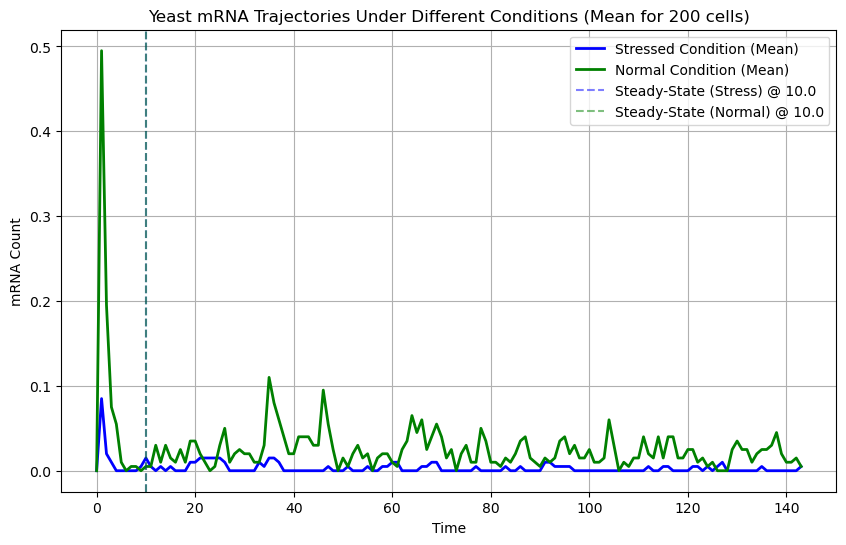

In [9]:
# Plots
plot_mRNA_trajectory(parameter_sets, time_points, stress_trajectories, normal_trajectories)